In [3]:
import sys
import os
import requests

import torch
import torch.nn as nn
import numpy as np

import argparse
import random
import shutil
import tqdm

import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from functools import partial

from timm.models.vision_transformer import PatchEmbed, Block
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader
import pytorch_warmup as warmup

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Split train test (no need to run this cell)

In [3]:
split = 0.85
data_dir = 'chart_data/'

print('loading dataset...')
src_paths = []
for file in os.listdir(data_dir):
    path = os.path.join(data_dir, file)
    #if imghdr.what(path) == None:
    #    continue
    src_paths.append(path)
random.shuffle(src_paths)

# separate the paths
border = int(split * len(src_paths))
train_paths = src_paths[:border]
test_paths = src_paths[border:]
print('train images: %d images.' % len(train_paths))
print('test images: %d images.' % len(test_paths))

# create dst directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
if (os.path.exists(train_dir) == False) and (os.path.exists(test_dir) == False):
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # move the image files
    pbar = tqdm.tqdm(total=len(src_paths))
    for dset_paths, dset_dir in zip([train_paths, test_paths], [train_dir, test_dir]):
        for src_path in dset_paths:
            dst_path = os.path.join(dset_dir, os.path.basename(src_path))
            shutil.move(src_path, dst_path)
            pbar.update()
    pbar.close()


loading dataset...
train images: 17651 images.
test images: 3115 images.


100%|██████████| 20766/20766 [00:08<00:00, 2539.88it/s]


## Model

In [5]:
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs


    '''
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    '''
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        #noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        interval = self.patch_embed.patch_size[0]-2
        noise = torch.zeros((N, L), device=x.device)
        #noise[:, interval - 2::interval] = 1
        noise[:, interval - 1::interval] = 1

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
        
    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio):
        mask_ratio = 1/(self.patch_embed.patch_size[0]-2)
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

In [6]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    image = torch.einsum('chw->hwc', image) 
    
    # image is [H, W, 3]
    assert image.shape[2] == 3
    
    plt.imshow(torch.clip((image.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=11)
    plt.axis('off')
    return torch.clip((image.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int()

def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img) / 255.

    assert img.shape == (224, 224, 3)

    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    
    return torch.tensor(img)

def load_data(data_path):
    files = os.listdir(data_path)
    num_images = len(files)
    
    train = torch.empty((num_images, 224, 224, 3))
    
    for id, file in enumerate(files):
        file_path = os.path.join(data_path, file)
        train[id] = load_image(file_path)
        
    train = torch.einsum('nhwc->nchw', train)
    return train 
        

def run_one_image(img, model):
    x = img.unsqueeze(dim=0)

    # run MAE
    with torch.no_grad():
        _, y, mask = model(x.float(), mask_ratio=1/(model.patch_embed.patch_size[0] - 2))
        y = model.unpatchify(y)
        y = y.detach()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = mask.detach()
    
    print(mask.size(), x.size())
    
    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    output = show_image(im_paste[0], "reconstruction + visible")

    #plt.show()

    return output

In [7]:
model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
#train = load_data("chart_data/train")
test = load_data("chart_data/test")

model = model.to(device)
#train = train.to(device)

In [8]:
#checkpoint = torch.load('mae_visualize_vit_large_ganloss.pth')
#model.load_state_dict(checkpoint['model'], strict=False)
model.load_state_dict(torch.load("temp_model_parameters40.pth"))

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

C:\Users\rebei\AppData\Local\Temp\ipykernel_32576\1020273444.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("temp_model_parameters40.pt

Total parameters: 329541888
Trainable parameters: 329239296


In [28]:
from torch.cuda.amp import autocast

#scaler = GradScaler()

def set_discrim_lr(model, lr, lr_decay):
    """
    Set discriminative learning rate across model layers,
    using lower learning rates on deeper layers of the network by a factor of `lr_decay`
    """  
    parameters = []
    
    cur_params = []
    cur_layer = None

    for name, param in reversed(list(model.named_parameters())):
        if not param.requires_grad:
            continue
        
        if name.count('.') == 0:
            layer = name
        else:
            layer = name.split('.')[:-1]
        
        if cur_params and layer != cur_layer:
            parameters.append({'params': cur_params, 'lr': lr})
            cur_params = []
            
            lr *= lr_decay
            
        cur_params.append(param)
        cur_layer = layer
        
    parameters.append({'params': cur_params, 'lr': lr})
    return parameters
      
def fine_tune(model, train, num_epochs=50, batch_size=96):
    lr = 7e-4
    lr_decay = 0.97
     
    param_groups = set_discrim_lr(model, lr, lr_decay)
    optimizer = torch.optim.AdamW(
        param_groups,
        betas=(0.9, 0.999),
        lr=lr,
        weight_decay=0.05,
    ) 
    
    #warmup_epochs = 1 #5
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    #warmup_scheduler = warmup.UntunedLinearWarmup(optimizer, last_step=warmup_epochs)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True) 
    #test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True) 
    for epoch in range(40, num_epochs):
        print([params['lr'] for params in optimizer.param_groups])
        #model.train(True)
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)

            optimizer.zero_grad()
            # Forward pass
            with autocast():  # Mixed precision
                loss, _, _ = model(batch, mask_ratio=1/(model.patch_embed.patch_size[0] - 2))
            
            # Backward pass
            #scaler.scale(loss).backward()
            #scaler.step(optimizer)
            #scaler.update()
            
            loss.backward()
            optimizer.step()
            
            #with warmup_scheduler.dampening():
            #    scheduler.step() 

            torch.cuda.empty_cache()
            gc.collect()
            mem = torch.cuda.memory_allocated(device)
                
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Train Loss: {loss.item()}, Memory (GB): {mem >> 30}')
            #print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")

        '''
        if epoch % 3 == 0:
            # switch to evaluation mode
            model.eval()
            for batch_idx, batch in enumerate(test_loader):
                batch = batch.to(device)
    
                # Forward pass
                with autocast():  # Mixed precision
                    loss, _, _ = model(batch, mask_ratio=1/(model.patch_embed.patch_size[0] - 2))
    
                torch.cuda.empty_cache()
                gc.collect()
                mem = torch.cuda.memory_allocated(device)
                    
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Test Loss: {loss.item()}, Memory (GB): {mem >> 30}')
                print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
        '''

In [8]:
import gc
#torch.cuda.empty_cache()
#gc.collect()
fine_tune(model, train)

[1.5007503751875938e-06, 1.4257128564282141e-06, 1.3544272136068034e-06, 1.2867058529264632e-06, 1.22237056028014e-06, 1.1612520322661327e-06, 1.103189430652826e-06, 1.0480299591201848e-06, 9.956284611641754e-07, 9.458470381059664e-07, 8.98554686200668e-07, 8.536269518906346e-07, 8.109456042961028e-07, 7.703983240812976e-07, 7.318784078772328e-07, 6.952844874833711e-07, 6.605202631092025e-07, 6.274942499537424e-07, 5.961195374560553e-07, 5.663135605832524e-07, 5.379978825540898e-07, 5.110979884263852e-07, 4.85543089005066e-07, 4.612659345548126e-07, 4.382026378270719e-07, 4.162925059357183e-07, 3.9547788063893234e-07, 3.757039866069857e-07, 3.569187872766364e-07, 3.3907284791280456e-07, 3.2211920551716433e-07, 3.060132452413061e-07, 2.907125829792408e-07, 2.7617695383027873e-07, 2.6236810613876475e-07, 2.492497008318265e-07, 2.3678721579023518e-07, 2.249478550007234e-07, 2.137004622506872e-07, 2.0301543913815282e-07, 1.9286466718124518e-07, 1.832214338221829e-07, 1.7406036213107374e-07

C:\Users\rebei\AppData\Local\Temp\ipykernel_7876\2620436565.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch 1, Batch 0, Train Loss: 0.39434942603111267, Memory (GB): 4
Epoch 1, Batch 1, Train Loss: 0.3899467885494232, Memory (GB): 4
Epoch 1, Batch 2, Train Loss: 0.43875449895858765, Memory (GB): 4
Epoch 1, Batch 3, Train Loss: 0.37732642889022827, Memory (GB): 4
Epoch 1, Batch 4, Train Loss: 0.4096970558166504, Memory (GB): 4
Epoch 1, Batch 5, Train Loss: 0.40361282229423523, Memory (GB): 4
Epoch 1, Batch 6, Train Loss: 0.39373573660850525, Memory (GB): 4
Epoch 1, Batch 7, Train Loss: 0.4254646897315979, Memory (GB): 4
Epoch 1, Batch 8, Train Loss: 0.4329836666584015, Memory (GB): 4
Epoch 1, Batch 9, Train Loss: 0.4537976384162903, Memory (GB): 4
Epoch 1, Batch 10, Train Loss: 0.443233460187912, Memory (GB): 4
Epoch 1, Batch 11, Train Loss: 0.4639301002025604, Memory (GB): 4
Epoch 1, Batch 12, Train Loss: 0.38897642493247986, Memory (GB): 4
Epoch 1, Batch 13, Train Loss: 0.3787388801574707, Memory (GB): 4
Epoch 1, Batch 14, Train Loss: 0.4357461929321289, Memory (GB): 4
Epoch 1, Batch 

KeyboardInterrupt: 

In [9]:
torch.cuda.empty_cache()
gc.collect()
torch.save(model.state_dict(), "temp_model_parameters3.pth")

In [12]:
import gc
fine_tune(model, train)

[1.5007503751875938e-06, 1.4257128564282141e-06, 1.3544272136068034e-06, 1.2867058529264632e-06, 1.22237056028014e-06, 1.1612520322661327e-06, 1.103189430652826e-06, 1.0480299591201848e-06, 9.956284611641754e-07, 9.458470381059664e-07, 8.98554686200668e-07, 8.536269518906346e-07, 8.109456042961028e-07, 7.703983240812976e-07, 7.318784078772328e-07, 6.952844874833711e-07, 6.605202631092025e-07, 6.274942499537424e-07, 5.961195374560553e-07, 5.663135605832524e-07, 5.379978825540898e-07, 5.110979884263852e-07, 4.85543089005066e-07, 4.612659345548126e-07, 4.382026378270719e-07, 4.162925059357183e-07, 3.9547788063893234e-07, 3.757039866069857e-07, 3.569187872766364e-07, 3.3907284791280456e-07, 3.2211920551716433e-07, 3.060132452413061e-07, 2.907125829792408e-07, 2.7617695383027873e-07, 2.6236810613876475e-07, 2.492497008318265e-07, 2.3678721579023518e-07, 2.249478550007234e-07, 2.137004622506872e-07, 2.0301543913815282e-07, 1.9286466718124518e-07, 1.832214338221829e-07, 1.7406036213107374e-07

C:\Users\rebei\AppData\Local\Temp\ipykernel_29764\855433317.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch 5, Batch 0, Train Loss: 0.2641275227069855, Memory (GB): 7
Epoch 5, Batch 1, Train Loss: 0.2763296961784363, Memory (GB): 7
Epoch 5, Batch 2, Train Loss: 0.3260619640350342, Memory (GB): 7
Epoch 5, Batch 3, Train Loss: 0.29032576084136963, Memory (GB): 7
Epoch 5, Batch 4, Train Loss: 0.2693054676055908, Memory (GB): 7
Epoch 5, Batch 5, Train Loss: 0.27935194969177246, Memory (GB): 7
Epoch 5, Batch 6, Train Loss: 0.23872263729572296, Memory (GB): 7
Epoch 5, Batch 7, Train Loss: 0.2677673101425171, Memory (GB): 7
Epoch 5, Batch 8, Train Loss: 0.2736033499240875, Memory (GB): 7
Epoch 5, Batch 9, Train Loss: 0.2807002365589142, Memory (GB): 7
Epoch 5, Batch 10, Train Loss: 0.29847589135169983, Memory (GB): 7
Epoch 5, Batch 11, Train Loss: 0.25968363881111145, Memory (GB): 7
Epoch 5, Batch 12, Train Loss: 0.274177610874176, Memory (GB): 7
Epoch 5, Batch 13, Train Loss: 0.31476983428001404, Memory (GB): 7
Epoch 5, Batch 14, Train Loss: 0.2956920266151428, Memory (GB): 7
Epoch 5, Batch 

KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), "temp_model_parameters29.pth")

In [26]:
import gc
fine_tune(model, train)

[0.0001, 9.7e-05, 9.409e-05, 9.12673e-05, 8.8529281e-05, 8.587340257e-05, 8.329720049289999e-05, 8.079828447811299e-05, 7.83743359437696e-05, 7.60231058654565e-05, 7.37424126894928e-05, 7.1530140308808e-05, 6.938423609954376e-05, 6.730270901655745e-05, 6.528362774606072e-05, 6.332511891367889e-05, 6.142536534626853e-05, 5.958260438588047e-05, 5.7795126254304054e-05, 5.606127246667493e-05, 5.437943429267468e-05, 5.274805126389444e-05, 5.11656097259776e-05, 4.9630641434198275e-05, 4.814172219117233e-05, 4.669747052543716e-05, 4.5296546409674046e-05, 4.393765001738382e-05, 4.2619520516862305e-05, 4.134093490135643e-05, 4.010070685431574e-05, 3.889768564868627e-05, 3.773075507922568e-05, 3.659883242684891e-05, 3.550086745404344e-05, 3.4435841430422135e-05, 3.340276618750947e-05, 3.240068320188419e-05, 3.142866270582766e-05, 3.0485802824652827e-05, 2.957122873991324e-05, 2.8684091877715842e-05, 2.7823569121384366e-05, 2.6988862047742834e-05, 2.617919618631055e-05, 2.5393820300721232e-05, 2.

C:\Users\rebei\AppData\Local\Temp\ipykernel_20296\437713335.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Epoch 30, Batch 0, Train Loss: 0.061187975108623505, Memory (GB): 7
Epoch 30, Batch 1, Train Loss: 0.06359926611185074, Memory (GB): 7
Epoch 30, Batch 2, Train Loss: 0.05394243076443672, Memory (GB): 7
Epoch 30, Batch 3, Train Loss: 0.06585253775119781, Memory (GB): 7
Epoch 30, Batch 4, Train Loss: 0.057372547686100006, Memory (GB): 7
Epoch 30, Batch 5, Train Loss: 0.06427426636219025, Memory (GB): 7
Epoch 30, Batch 6, Train Loss: 0.055464811623096466, Memory (GB): 7
Epoch 30, Batch 7, Train Loss: 0.05922051891684532, Memory (GB): 7
Epoch 30, Batch 8, Train Loss: 0.06786184012889862, Memory (GB): 7
Epoch 30, Batch 9, Train Loss: 0.06415615975856781, Memory (GB): 7
Epoch 30, Batch 10, Train Loss: 0.07264306396245956, Memory (GB): 7
Epoch 30, Batch 11, Train Loss: 0.058965977281332016, Memory (GB): 7
Epoch 30, Batch 12, Train Loss: 0.06786637008190155, Memory (GB): 7
Epoch 30, Batch 13, Train Loss: 0.05905142426490784, Memory (GB): 7
Epoch 30, Batch 14, Train Loss: 0.05926058441400528, M

In [27]:
#torch.save(model.state_dict(), "temp_model_parameters40.pth")

In [ ]:
from torch.cuda.amp import autocast
import gc
#model.eval()
# .35 after 26 epochs
test_loader = torch.utils.data.DataLoader(test, batch_size = 96, shuffle=True) 

for batch_idx, batch in enumerate(test_loader):
    batch = batch.to(device)

    # Forward pass
    with autocast():  # Mixed precision
        loss, _, _ = model(batch, mask_ratio=1/(model.patch_embed.patch_size[0] - 2))

    print("Random batch validation loss:", loss)
    torch.cuda.empty_cache()
    gc.collect()
    break

In [534]:
#test = load_data("charts2024")
test = load_data("chart_data/test")

tensor([[[ 84,  83,  84],
         [ 84,  83,  84],
         [ 84,  83,  84],
         ...,
         [ 84,  83,  84],
         [ 84,  83,  84],
         [ 84,  83,  84]],

        [[254, 255, 255],
         [254, 255, 255],
         [254, 255, 255],
         ...,
         [254, 255, 255],
         [254, 255, 255],
         [254, 255, 255]],

        [[254, 255, 255],
         [254, 255, 255],
         [254, 255, 255],
         ...,
         [254, 255, 255],
         [254, 255, 255],
         [254, 255, 255]],

        ...,

        [[254, 255, 255],
         [254, 255, 255],
         [254, 255, 255],
         ...,
         [254, 255, 255],
         [254, 255, 255],
         [254, 255, 255]],

        [[254, 255, 255],
         [254, 255, 255],
         [254, 255, 255],
         ...,
         [254, 255, 255],
         [254, 255, 255],
         [254, 255, 255]],

        [[254, 255, 255],
         [254, 255, 255],
         [254, 255, 255],
         ...,
         [254, 255, 255],
        

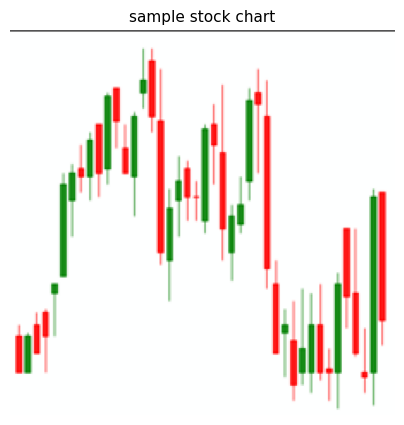

In [7]:
#test = load_data("chart_data/test")
img = test[924].to(device) #50
#42
plt.rcParams['figure.figsize'] = [5, 5]
show_image(img, title = 'sample stock chart')

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


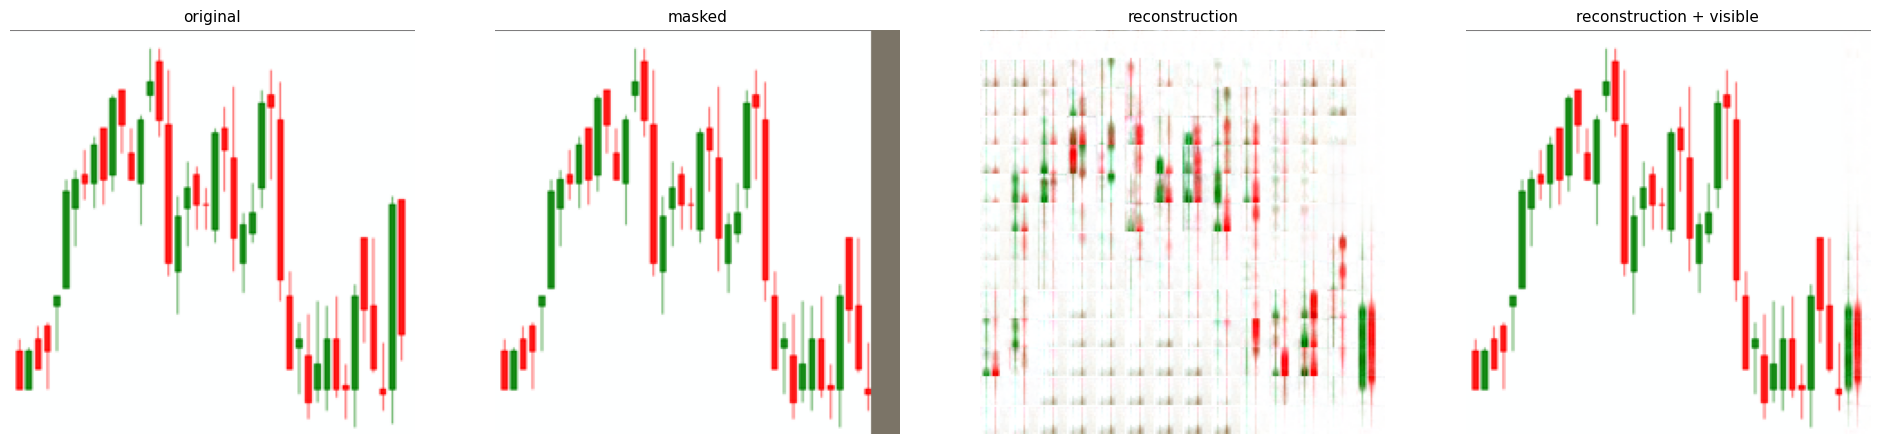

In [8]:
output = run_one_image(img, model)

In [139]:
import cv2
def dominant_color(image):

    # Convert image to a numpy array
    #image_array = np.array(image)
    
 
    # Convert image to a numpy array (OpenCV uses BGR, so convert to array first)
    #print(image.shape)
    image = image.astype(np.uint8)
    image_array = np.array(image).reshape((224, 5, 3))
    #print(image_array.shape)
    #image_array = image_array[:, 2:3, :]

    np.set_printoptions(threshold=np.inf)  # This disables truncation of large arrays
    
    # Convert to HSV color space using OpenCV (it expects BGR, so reorder)
    #image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
    
    # Extract HSV channels
    hue = image_hsv[:, :, 0]
    #print(hue)
    saturation = image_hsv[:, :, 1]
    value = image_hsv[:, :, 2]

     # Define Red and Green Hue Ranges more carefully
    # Red Hue Range: 0-10 and 170-180 degrees
    red_pixels = ((hue >= 0) & (hue <= 12)) | ((hue >= 165) & (hue <= 180))
    
    # Green Hue Range: 35-85 degrees
    green_pixels = (hue >= 30) & (hue <= 90)
    
    # Optional: Apply thresholds for saturation and brightness
    # Filter out low saturation and low value pixels that might cause misclassification
    high_saturation = saturation > 2.0  # Threshold for saturation
    high_value = value > 2.8  # Threshold for brightness (value)
    
    # Apply these thresholds to both red and green pixels
    red_pixels = red_pixels & high_saturation & high_value
    green_pixels = green_pixels & high_saturation & high_value

    # Apply the non-white pixel mask to both red and green pixels
    #red_pixels = red_pixels & non_white_pixels
    #green_pixels = green_pixels & non_white_pixels
    
    # Calculate the weighted sum of intensity (saturation and value) for red and green
    red_intensity = np.sum(value[red_pixels])
    green_intensity = np.sum(value[green_pixels])
    
    # Compare the summed intensities of red and green
    if red_intensity > green_intensity:
        return 0
    elif green_intensity > red_intensity:
        return 1
    else:
        return -1

#result = dominant_color(np.array(output[:, -15:-10, :]))
#print(result)

In [10]:
def up_or_down(outputs):
    """
        outputs: shape [N, 3, 224, 224]
        output: shape [N, 2]
    """
    N = outputs.size()[0]
   
    images = (torch.einsum('nchw->nhwc', outputs).cpu() * imagenet_std + imagenet_mean) - 1 # subtract white
    sec_last, last = torch.split(images[:, 1:, -15:-5,:], 5, dim=2) # 2, [N, 223, 5, 3]

    res = torch.empty((N, 2))
   
    for idx, slice in enumerate(sec_last):
        slice = slice[torch.linalg.vector_norm(slice, dim=2) >= 1e-4] # remove white pixels
        if slice.size()[0] == 0:
            continue # bad image
        res[idx, 0] = torch.mode(slice.argmax(dim=1)).values.item()

    for idx, slice in enumerate(last):
        slice = slice[torch.linalg.vector_norm(slice, dim=2) >= 1e-4] # remove white pixels
        if slice.size()[0] == 0:
            continue # bad image
        res[idx, 1] = torch.mode(slice.argmax(dim=1)).values.item()
       
    return res[0, 0], res[0, 1]

#up_or_down(torch.reshape(img, (1, 3, 224, 224)))

In [114]:
test = load_data("chart_data/test")
correct_day1_predictions = 0
correct_day2_predictions = 0
correct_days_predictions = 0
cor_candle1_ind = []
incorrect = []
cor_candle2_ind = []
cor_candles_ind = []
candle_1_output_labels = []
candle_1_true_labels = []
matplotlib.use('Agg')
for i in range(len(test)):
    #print(i)
    img = test[i].to(device)
    output = run_one_image(img, model)
    candle_1_output = dominant_color(np.array(output[:, -15:-10, :]))
    candle_2_output = dominant_color(np.array(output[:, -10:-5, :]))
    candle1_img, candle2_img = up_or_down(torch.reshape(img, (1, 3, 224, 224)))
    candle_1_true_labels.append(candle1_img)
    candle_1_output_labels.append(candle_1_output)
    if candle_1_output == candle1_img: 
        correct_day1_predictions += 1
        cor_candle1_ind.append(i)
    else:
        incorrect.append(i)
    if candle_2_output == candle2_img: 
        correct_day2_predictions += 1
        cor_candle2_ind.append(i)
    if candle_2_output == candle2_img and candle_1_output == candle1_img:
        correct_days_predictions += 1
        cor_candles_ind.append(i)
        
print("Next Day Accuracy (%): ", correct_day1_predictions/len(test) * 100)
print("Second Day Accuracy (%): ", correct_day2_predictions/len(test) * 100)
print("Both Day Accuracy (%): ", correct_days_predictions/len(test) * 100)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1,

In [115]:
y_pred = np.array(candle_1_output_labels)
y_true = np.array(candle_1_true_labels)
# Compute TP, FP, TN, FN
TP = np.sum((y_true == 1) & (y_pred == 1))
FP = np.sum((y_true == 0) & (y_pred == 1))
TN = np.sum((y_true == 0) & (y_pred == 0))
FN = np.sum((y_true == 1) & (y_pred == 0))

# Compute precision, recall, f1-score, accuracy
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN)

# Print the results
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

True Positives (TP): 1224
False Positives (FP): 429
True Negatives (TN): 765
False Negatives (FN): 617
Precision: 0.7405
Recall: 0.6649
F1-score: 0.7006
Accuracy: 0.6554


In [140]:
test = load_data("chartsfinal")
correct_day1_predictions = 0
correct_day2_predictions = 0
correct_days_predictions = 0
cor_candle1_ind = []
cor_candle2_ind = []
cor_candles_ind = []
candle_1_output_labels = []
candle_1_true_labels = []
matplotlib.use('Agg')
for i in range(len(test)):
    #print(i)
    img = test[i].to(device)
    output = run_one_image(img, model)
    candle_1_output = dominant_color(np.array(output[:, -15:-10, :]))
    candle_2_output = dominant_color(np.array(output[:, -10:-5, :]))
    candle1_img, candle2_img = up_or_down(torch.reshape(img, (1, 3, 224, 224)))
    candle_1_true_labels.append(candle1_img)
    candle_1_output_labels.append(candle_1_output)
    if candle_1_output == candle1_img: 
        correct_day1_predictions += 1
        cor_candle1_ind.append(i)
    if candle_2_output == candle2_img: 
        correct_day2_predictions += 1
        cor_candle2_ind.append(i)
    if candle_2_output == candle2_img and candle_1_output == candle1_img:
        correct_days_predictions += 1
        cor_candles_ind.append(i)
        
print("Next Day Accuracy (%): ", correct_day1_predictions/len(test) * 100)
print("Second Day Accuracy (%): ", correct_day2_predictions/len(test) * 100)
print("Both Day Accuracy (%): ", correct_days_predictions/len(test) * 100)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1,

In [141]:
y_pred = np.array(candle_1_output_labels)
y_true = np.array(candle_1_true_labels)
# Compute TP, FP, TN, FN
TP = np.sum((y_true == 1) & (y_pred == 1))
FP = np.sum((y_true == 0) & (y_pred == 1))
TN = np.sum((y_true == 0) & (y_pred == 0))
FN = np.sum((y_true == 1) & (y_pred == 0))

# Compute precision, recall, f1-score, accuracy
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
accuracy = (TP + TN) / (TP + FP + TN + FN)

# Print the results
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

True Positives (TP): 108
False Positives (FP): 133
True Negatives (TN): 146
False Negatives (FN): 71
Precision: 0.4481
Recall: 0.6034
F1-score: 0.5143
Accuracy: 0.5546


In [138]:
import random

def results_figure(indices, model, filename):
    # make the plt figure larger
    #plt.rcParams['figure.figsize'] = [8, 5]
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 18))
    sample_indices = random.sample(indices, 4)
    row = 0
    for i in sample_indices:
        print(i)
        img = test[i].to(device)
        x = img.unsqueeze(dim=0)
    
        # run MAE
        with torch.no_grad():
            _, y, mask = model(x.float(), mask_ratio=1/(model.patch_embed.patch_size[0] - 2))
            y = model.unpatchify(y)
            y = y.detach()
    
        # visualize the mask
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = mask.detach()
        
        print(mask.size(), x.size())
        
        # masked image
        im_masked = x * (1 - mask)
    
        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask
    
    
        #plt.subplot(row, 3, 1)
        #show_image(x[0], "original")
        x1 = torch.einsum('chw->hwc', x[0]) 
        axes[row, 0].imshow(torch.clip((x1.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    
        #plt.subplot(row, 3, 2)
        #show_image(im_masked[0], "masked")
        im_masked1 = torch.einsum('chw->hwc', im_masked[0]) 
        axes[row, 1].imshow(torch.clip((im_masked1.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())


        im_paste1 = torch.einsum('chw->hwc', im_paste[0]) 
        axes[row, 2].imshow(torch.clip((im_paste1.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())

        axes[row, 0].axis('off')
        axes[row, 1].axis('off')
        axes[row, 2].axis('off')
        #plt.subplot(1, 4, 3)
        #show_image(y[0], "reconstruction")
    
        #plt.subplot(row, 3, 3)
        #output = show_image(im_paste[0], "reconstruction + visible")
        # Plot data on each subplot
        row+= 1
    # Add column labels manually
    fig.text(0.15, 0.99, 'Original', ha='center', va='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.99, 'Masked', ha='center', va='center', fontsize=14, fontweight='bold')
    fig.text(0.85, 0.99, 'Reconstruction + Original', ha='center', va='center', fontsize=14, fontweight='bold')
    #plt.subplots_adjust(wspace=0.5, hspace=0)  # Remove all space between subplots
    plt.tight_layout(pad=1)  # Ensure subplots are as tight as possible with no extra padding
    plt.savefig(filename)
results_figure(cor_candle1_ind, model, 'correct1.png')

2280
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
186
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
2941
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
398
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


In [117]:
results_figure(cor_candles_ind, model, 'correctboth.png')

2420
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
845
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
1858
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
2520
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


In [128]:
results_figure(incorrect, model, 'incorrect1.png')

1266
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
2764
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
1015
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
1441
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


In [103]:
test = load_data("chart_data/test")

In [105]:
img = test[2339].to(device)
output = run_one_image(img, model)
print(dominant_color(np.array(output[:, -15:-10, :])))
dominant_color(np.array(output[:, -10:-5, :]))

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
1


1

In [106]:
up_or_down(torch.reshape(img, (1, 3, 224, 224)))

(tensor(1.), tensor(1.))